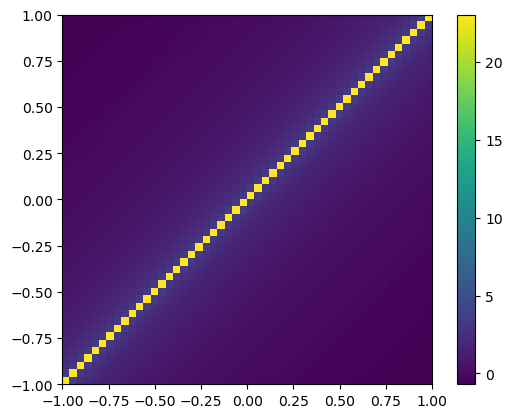

In [1144]:
###################
# import statements
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import vmap
from matplotlib import colors
import pickle

from torch import exp, cos, sin, abs, sum


# set default torch device. On Apple Si, use 'cpu', 'mps' is significantly slower. If nVidia GPU available, try using 'cuda'.
torch.set_default_device('cpu') 


#####################
# function definition

def f(Q): # 1/distance
    return torch.sqrt(1/( (Q[0] - Q[1] )**2 +1e-20))

f_vmap = vmap(f) #vectorize over tensors

def relu(x): #ReLU non-linear activation function
    return x*(x>=0)

#def relu(x): #leaky ReLU
#    return x*(x>=0) + 0.1*(x<0)

n_xgrid_points = 50

x_min, x_max = -1, 1

xgrid = torch.linspace(x_min,x_max,n_xgrid_points)
#powers = torch.linspace(-2.5,.2,n_xgrid_points) #sample powers
#points = 10**powers #calculate sample points

#xgrid = torch.cat(( -torch.flip(points, dims = [0]), points )) #flip and negate sample points, then concatenate with original points to for xgrid

n_points = xgrid.size()[0]

X, Y = torch.meshgrid(xgrid,xgrid)

Q = torch.zeros(n_points**2,2)
Q[:,0] = X.reshape(-1)
Q[:,1] = Y.reshape(-1)

im = f_vmap(Q)


plt.imshow(torch.log(im.reshape(n_points,n_points)),origin='lower',extent=[x_min,x_max,x_min,x_max])
plt.colorbar()
plt.show()



***Parameter Initialization***

Here I define the neural network structure and initialize the parameters.

To reduce the amount of gradient descent epochs needed, the code makes many random guesses and saves the configuration with the lowest loss value.

100%|██████████| 75/75 [00:02<00:00, 35.61it/s]


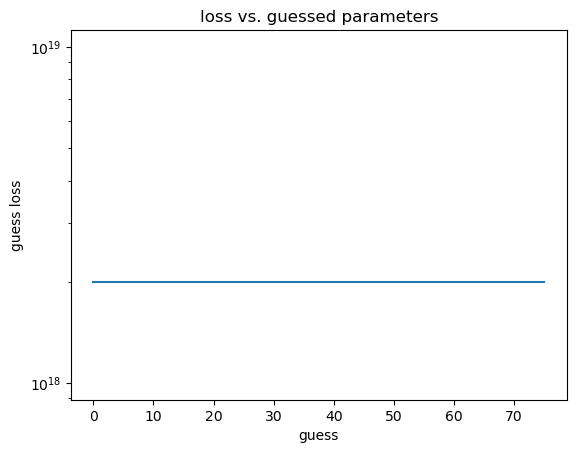

In [1146]:
##########
# setup definition

layer_size = 32 #number of 'neurons' in each layer

n_guesses = 75 #number of random guesses to search before running gradient descent. Helps avoid starting at a high-loss configuration and needing to descend down over more iterations.

param_sigma = .75

reg_value = 1e-10 #regularization lambda

n_inputs = 2
#define number of neurons in each layer. Using uniform layer sizes here for convenience in plotting activations later
n0 = layer_size
n1 = layer_size
n2 = layer_size
n3 = layer_size

#randomize initial parameters
w0 = param_sigma*torch.randn(n_inputs,n0, requires_grad = True)
w1 = param_sigma*torch.randn(n0,n1, requires_grad = True)
w2 = param_sigma*torch.randn(n1,n2, requires_grad = True)
w3 = param_sigma*torch.randn(n2,n3, requires_grad = True)
wf = param_sigma*torch.randn(n3, requires_grad = True)

b0 = param_sigma*torch.randn(n0, requires_grad = True)
b1 = param_sigma*torch.randn(n1, requires_grad = True)
b2 = param_sigma*torch.randn(n2, requires_grad = True)
b3 = param_sigma*torch.randn(n3, requires_grad = True)

#####################
# function definition

def forward(Q): #forward pass evaluation
    l0 = relu(w0.T@Q + b0)
    l1 = relu(w1@l0 + b1)
    l2 = relu(w2@l1 + b2)
    l3 = relu(w3@l2 + b3)
    lf = wf*l3
    return torch.sum(lf)

def forward_activations(Q): #forward pass evaluation, returns activations instead of final fitted value
    l0 = relu(w0@Q + b0)
    l1 = relu(w1@l0 + b1)
    l2 = relu(w2@l1 + b2)
    l3 = relu(w3@l2 + b3)
    lf = wf*l3
    return l0, l1, l2, l3, lf

def loss2(step, values):
    return torch.mean( (step-values)**2) + reg_value*( torch.sum(w0**2) + torch.sum( w1**2 + w2**2 + w3**2 + wf**2 + b0**2 + b1**2 + b2**2 + b3**2 ) )

# vectorize forward passes
fv = torch.func.vmap(forward,in_dims=(0))
fwv = torch.func.vmap(forward_activations,in_dims=(0))


############
# main block

values = f_vmap(Q) #calculate true values from sampled points

loss_trials = torch.zeros(n_guesses+1) #initialize storage array

step = fv(Q) #calculate NN outputs from current parameters


loss_iter = loss2(step,values) #calculate loss from current parameters
loss_trials[0] = loss_iter #store loss value for initial guess

#clone out initial guess to storage tensors
w0_st = torch.clone(w0)
w1_st = torch.clone(w1)
w2_st = torch.clone(w2)
w3_st = torch.clone(w3)
wf_st = torch.clone(wf)
b0_st = torch.clone(b0)
b1_st = torch.clone(b1)
b2_st = torch.clone(b2)
b3_st = torch.clone(b3)

for i in tqdm.trange(n_guesses): #iterate over number of guesses
    
    #clone out current parameters
    w0_st.data = torch.clone(w0)
    w1_st.data = torch.clone(w1)
    w2_st.data = torch.clone(w2)
    w3_st.data = torch.clone(w3)
    wf_st.data = torch.clone(wf)
    b0_st.data = torch.clone(b0)
    b1_st.data = torch.clone(b1)
    b2_st.data = torch.clone(b2)
    b3_st.data = torch.clone(b3)

    #random guess for parameters
    w0 = param_sigma*torch.randn(n_inputs,n0, requires_grad = True)
    w1 = param_sigma*torch.randn(n0,n1, requires_grad = True)
    w2 = param_sigma*torch.randn(n1,n2, requires_grad = True)
    w3 = param_sigma*torch.randn(n2,n3, requires_grad = True)
    wf = param_sigma*torch.randn(n3, requires_grad = True)
    b0 = param_sigma*torch.randn(n0, requires_grad = True)
    b1 = param_sigma*torch.randn(n1, requires_grad = True)
    b2 = param_sigma*torch.randn(n2, requires_grad = True)
    b3 = param_sigma*torch.randn(n3, requires_grad = True)
    
    step = fv(Q) #calculate NN outputs from current parameters
    loss = loss2(step,values) #calculate loss from current parameters
    if lossval < loss_iter: #if loss for this guess is lower than previous guess:

        #clone out new parameters for storage
        w0_st.data = torch.clone(w0)
        w1_st.data = torch.clone(w1)
        w2_st.data = torch.clone(w2)
        w3_st.data = torch.clone(w3)
        wf_st.data = torch.clone(wf)
        
        b0_st.data = torch.clone(b0)
        b1_st.data = torch.clone(b1)
        b2_st.data = torch.clone(b2)
        b3_st.data = torch.clone(b3)
    
    loss_iter = loss #store running loss
    loss_trials[i+1] = loss_iter #store running loss

#after loop, clone out best paramater configuration
w0.data = torch.clone(w0_st)
w1.data = torch.clone(w1_st)
w2.data = torch.clone(w2_st)
w3.data = torch.clone(w3_st)
wf.data = torch.clone(wf_st)

b0.data = torch.clone(b0_st)
b1.data = torch.clone(b1_st)
b2.data = torch.clone(b2_st)
b3.data = torch.clone(b3_st)

w0.retain_grad()
w1.retain_grad()
w2.retain_grad()
w3.retain_grad()
wf.retain_grad()
b0.retain_grad()
b1.retain_grad()
b2.retain_grad()
b3.retain_grad()


#plot sorted loss history
plt.plot(np.sort(loss_trials.cpu().detach().numpy()))
plt.xlabel('guess') #plot formatting
plt.ylabel('guess loss')
plt.title('loss vs. guessed parameters')
plt.yscale('log')

***Gradient Descent Training***

Now apply gradient descent with some small modifications:

-At each iteration, if the current loss is the new minimum, store these 'optimal' parameters

-If loss increases for a set number of iterations, reset parameters to the current 'optimal' parameters

-If loss is stagnant (not decreasing faster than a set ratio per iteration) for a set number of iterations, add a small amount of noise to the parameters. Wait a set number of iterations before the stagnation counter is allowed to increase again.

After training, output parameters to a storage file.

100%|██████████| 2500/2500 [02:35<00:00, 16.12it/s]


The ratio of loss_opt to loss_init is 0.615


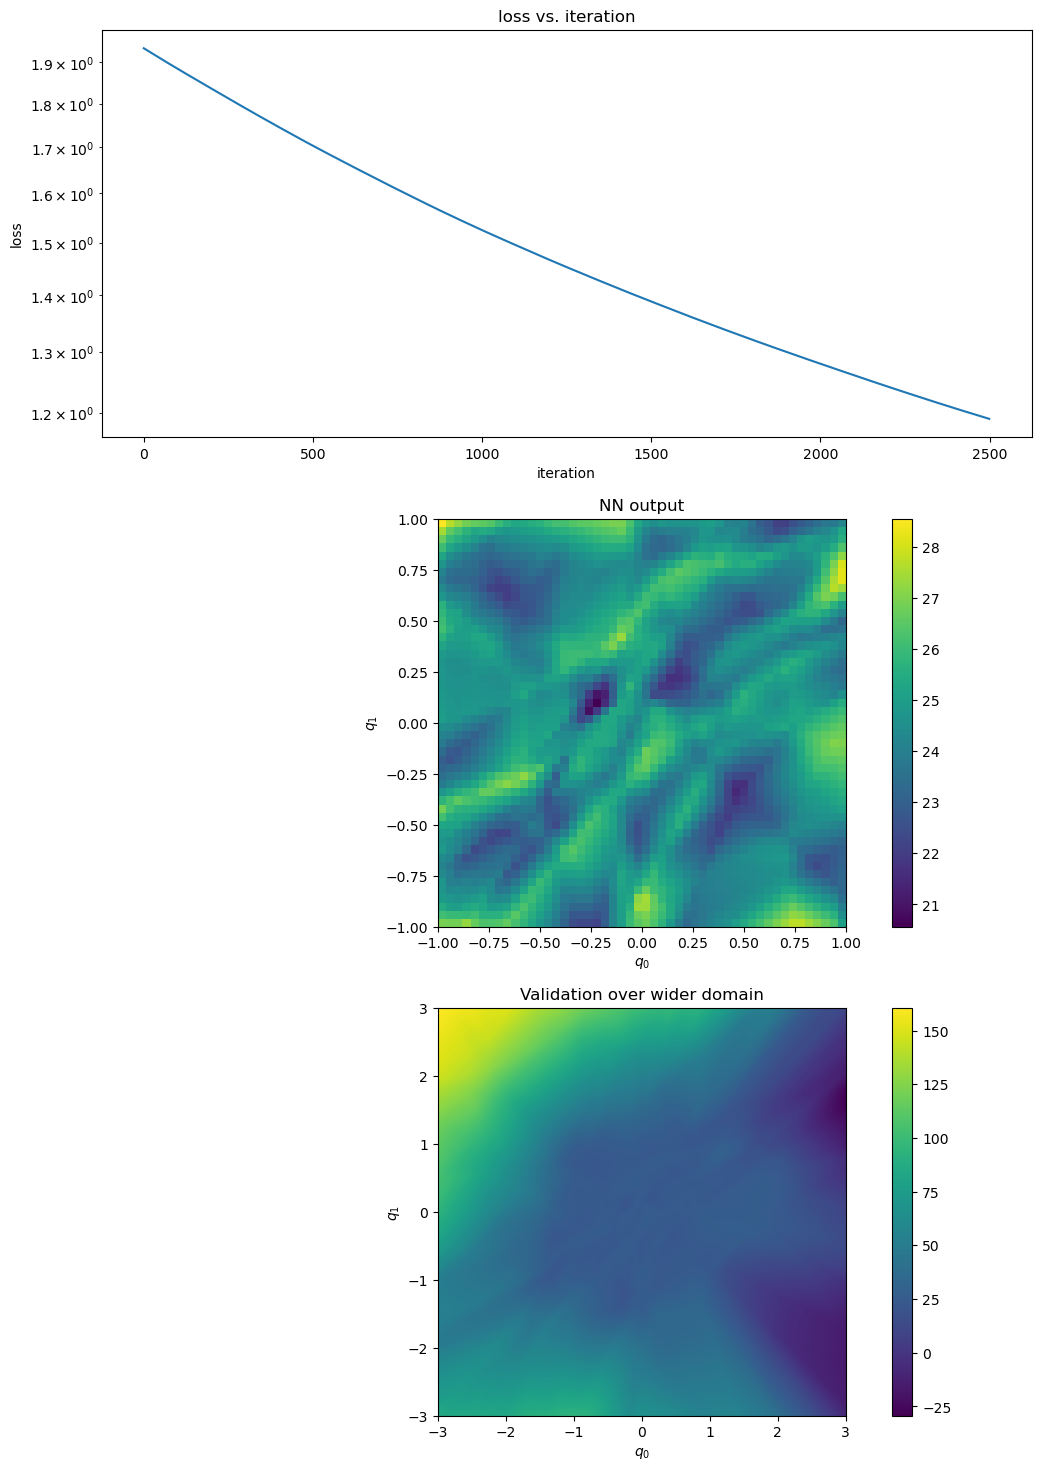

In [1166]:
###############
# problem setup

iterations = 2500 #number of epochs
learning_rate = 5e-6
#learning rate
lr_decrease = 0.995 #decrease lr by this ratio when loss increasing

#reg_value = 1e-12 #regularization lambda


increasing_threshold = 25 #threshold number of iterations to reset to optimal parameters after increasing loss. set to -1 to disable
stagnant_threshold = 100 #threshold number of iterations to perturb parameters if training stagnates. set to -1 to disable
stagnant_wait = 5000 #don't apply noise for this many iterations after a perturbation
stagnant_rate = 1 - learning_rate*(1e-0) #if ratio of current to previous loss larger than this, increment stagnant_count
noise_sigma = 5e-3 #if stagnant_threshold exceeded, perturb parameters by Gaussian noise with mean 1 and this value for sigma

lr = learning_rate #assign working learning rate
loss_history = torch.inf*torch.ones(iterations) #initialize loss storage array

#clone initial conditions as optimal parameters
w0_opt = torch.clone(w0)
w1_opt = torch.clone(w1)
w2_opt = torch.clone(w2)
w3_opt = torch.clone(w3)
wf_opt = torch.clone(wf)

b0_opt = torch.clone(b0)
b1_opt = torch.clone(b1)
b2_opt = torch.clone(b2)
b3_opt = torch.clone(b3)

#define counters
increasing_count = 0 
stagnant_count = 0
stagnant_wait_count = 0

increasing_reset_count = 0
stagnant_reset_count = 0

#create lists for iterations with intervention
increasing_iterations = []
stagnant_iterations = []

values = f(xgrid) #recalculate values in case xgrid samples have been changed


for i in tqdm.trange(iterations): #iterate
    step = fv(Q) #calculate NN values at curent parameters
    loss = loss2(step,values) #calculate loss function, including regularization term
    loss_history[i] = loss #store loss value
    
    stagnant_wait_count = torch.max(torch.tensor([0,stagnant_wait_count-1])) #decrement stagnant waiting period, but not below zero
    if loss == torch.min(loss_history): #if loss is best so far:
        increasing_count = torch.max(torch.tensor([0,increasing_count-1])) #decrease increasing_count, but not below zero

        #clone out parameters to optimal tensor
        w0_opt.data = torch.clone(w0)
        w1_opt.data = torch.clone(w1)
        w2_opt.data = torch.clone(w2)
        w3_opt.data = torch.clone(w3)
        wf_opt.data = torch.clone(wf)
        
        b0_opt.data = torch.clone(b0)
        b1_opt.data = torch.clone(b1)
        b2_opt.data = torch.clone(b2)
        b3_opt.data = torch.clone(b3)
        
    elif loss > loss_history[i-1]: #if loss increasing
        increasing_count += 1 #increment counter
        lr = lr*lr_decrease #decrease lr
        
    if loss/loss_history[i-1] > stagnant_rate and loss <= loss_history[i-1] and stagnant_wait_count == 0: #if loss stagnant and decreasing and not in waiting period:
        stagnant_count += 1 #increment counter
    else: #if not stagnant, decrement counter but not below zero
        stagnant_count = torch.max(torch.tensor([0,stagnant_count-1]))
        
    
    if increasing_count >= increasing_threshold and increasing_threshold > 0: #if increasing_count goes above threshold
        increasing_iterations.append(i) #store current iteration
        increasing_count = 0 #reset counter
        increasing_reset_count += 1 #increment intervention counter
        
        #clone optimal parameters to working parameters
        w0.data = torch.clone(w0_opt)
        w1.data = torch.clone(w1_opt)
        w2.data = torch.clone(w2_opt)
        w3.data = torch.clone(w3_opt)
        wf.data = torch.clone(wf_opt)
        
        b0.data = torch.clone(b0_opt)
        b1.data = torch.clone(b1_opt)
        b2.data = torch.clone(b2_opt)
        b3.data = torch.clone(b3_opt)

    if stagnant_count >= stagnant_threshold and stagnant_threshold > 0: #if stagnant for too long, perturb parameters.
        stagnant_iterations.append(i) #store current iteration
        stagnant_count = 0 #reset counter
        stagnant_wait_count = stagnant_wait
        stagnant_reset_count += 1 #increment intervention counter
        
        # add noise to parameters
        w0.data += noise_sigma*torch.randn(w0.shape)
        w1.data += noise_sigma*torch.randn(w1.shape)
        w2.data += noise_sigma*torch.randn(w2.shape)
        w3.data += noise_sigma*torch.randn(w3.shape)
        wf.data += noise_sigma*torch.randn(wf.shape)
        
        b0.data += noise_sigma*torch.randn(b0.shape)
        b1.data += noise_sigma*torch.randn(b1.shape)
        b2.data += noise_sigma*torch.randn(b2.shape)
        b3.data += noise_sigma*torch.randn(b3.shape)
    
    loss.backward(retain_graph=True) #call grad calculations

    #apply gradient descent step
    w0.data -= lr*w0.grad
    w1.data -= lr*w1.grad
    w2.data -= lr*w2.grad
    w3.data -= lr*w3.grad
    wf.data -= lr*wf.grad
    
    b0.data -= lr*b0.grad
    b1.data -= lr*b1.grad
    b2.data -= lr*b2.grad
    b3.data -= lr*b3.grad

    #zero all grads to prevent accumulation
    w0.grad.data = torch.zeros(n0)
    w1.grad.data = torch.zeros(n0,n1)
    w2.grad.data = torch.zeros(n1,n2)
    w3.grad.data = torch.zeros(n2,n3)
    wf.grad.data = torch.zeros(n3)

    b0.grad.data = torch.zeros(n0)
    b1.grad.data = torch.zeros(n1)
    b2.grad.data = torch.zeros(n2)
    b3.grad.data = torch.zeros(n3)

#after loop, clone out optimal parameters
w0.data = torch.clone(w0_opt)
w1.data = torch.clone(w1_opt)
w2.data = torch.clone(w2_opt)
w3.data = torch.clone(w3_opt)
wf.data = torch.clone(wf_opt)

b0.data = torch.clone(b0_opt)
b1.data = torch.clone(b1_opt)
b2.data = torch.clone(b2_opt)
b3.data = torch.clone(b3_opt)


#print(increasing_iterations)
#print(stagnant_iterations)

out = fv(Q).cpu().detach().numpy()
l_hist = loss_history.cpu().detach().numpy()

print(f'The ratio of loss_opt to loss_init is {l_hist.min()/l_hist[0]:.3f}')

fig, axs = plt.subplots(3,1,figsize=(12,18))

axs[0].plot(l_hist)
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')
axs[0].set_yscale('log')
axs[0].set_title('loss vs. iteration')

color_train = axs[1].imshow(out.reshape(n_xgrid_points,n_xgrid_points),extent=[x_min,x_max,x_min,x_max],origin = 'lower')
axs[1].set_xlabel(r'$q_0$')
axs[1].set_ylabel(r'$q_1$')
axs[1].set_title('NN output')
fig.colorbar(color_train, ax=axs[1])



n_xgrid_points1 = 1000
x_min1, x_max1 = -3, 3
xgrid1 = torch.linspace(x_min1,x_max1,n_xgrid_points1)
n_points1 = xgrid1.size()[0]
X1, Y1 = torch.meshgrid(xgrid1,xgrid1)
Q1 = torch.zeros(n_points1**2,2)
Q1[:,0] = X1.reshape(-1)
Q1[:,1] = Y1.reshape(-1)

im1 = fv(Q1).cpu().detach().numpy()

color_val = axs[2].imshow((im1.reshape(n_xgrid_points1,n_xgrid_points1) ) ,extent=[x_min1,x_max1,x_min1,x_max1],origin = 'lower')
axs[2].set_xlabel(r'$q_0$')
axs[2].set_ylabel(r'$q_1$')
axs[2].set_title('Validation over wider domain')
fig.colorbar(color_val, ax=axs[2])

plt.show()


##############################
# storing parameters and setup


obj = {'n0':n0,'n1':n1,'n2':n2,'n3':n3,'layer_size':layer_size,'w0': w0, 'w1': w1, 'w2': w2, 'w3': w3, 'wf': wf, 'b0': b0, 'b1': b1, 'b2': b2, 'b3': b3,'learning_rate':learning_rate,'iterations':iterations,'reg_value':reg_value}
file = open('param_store.pckl', 'wb')
pickle.dump(obj, file)
file.close()


***Visualization Activations***



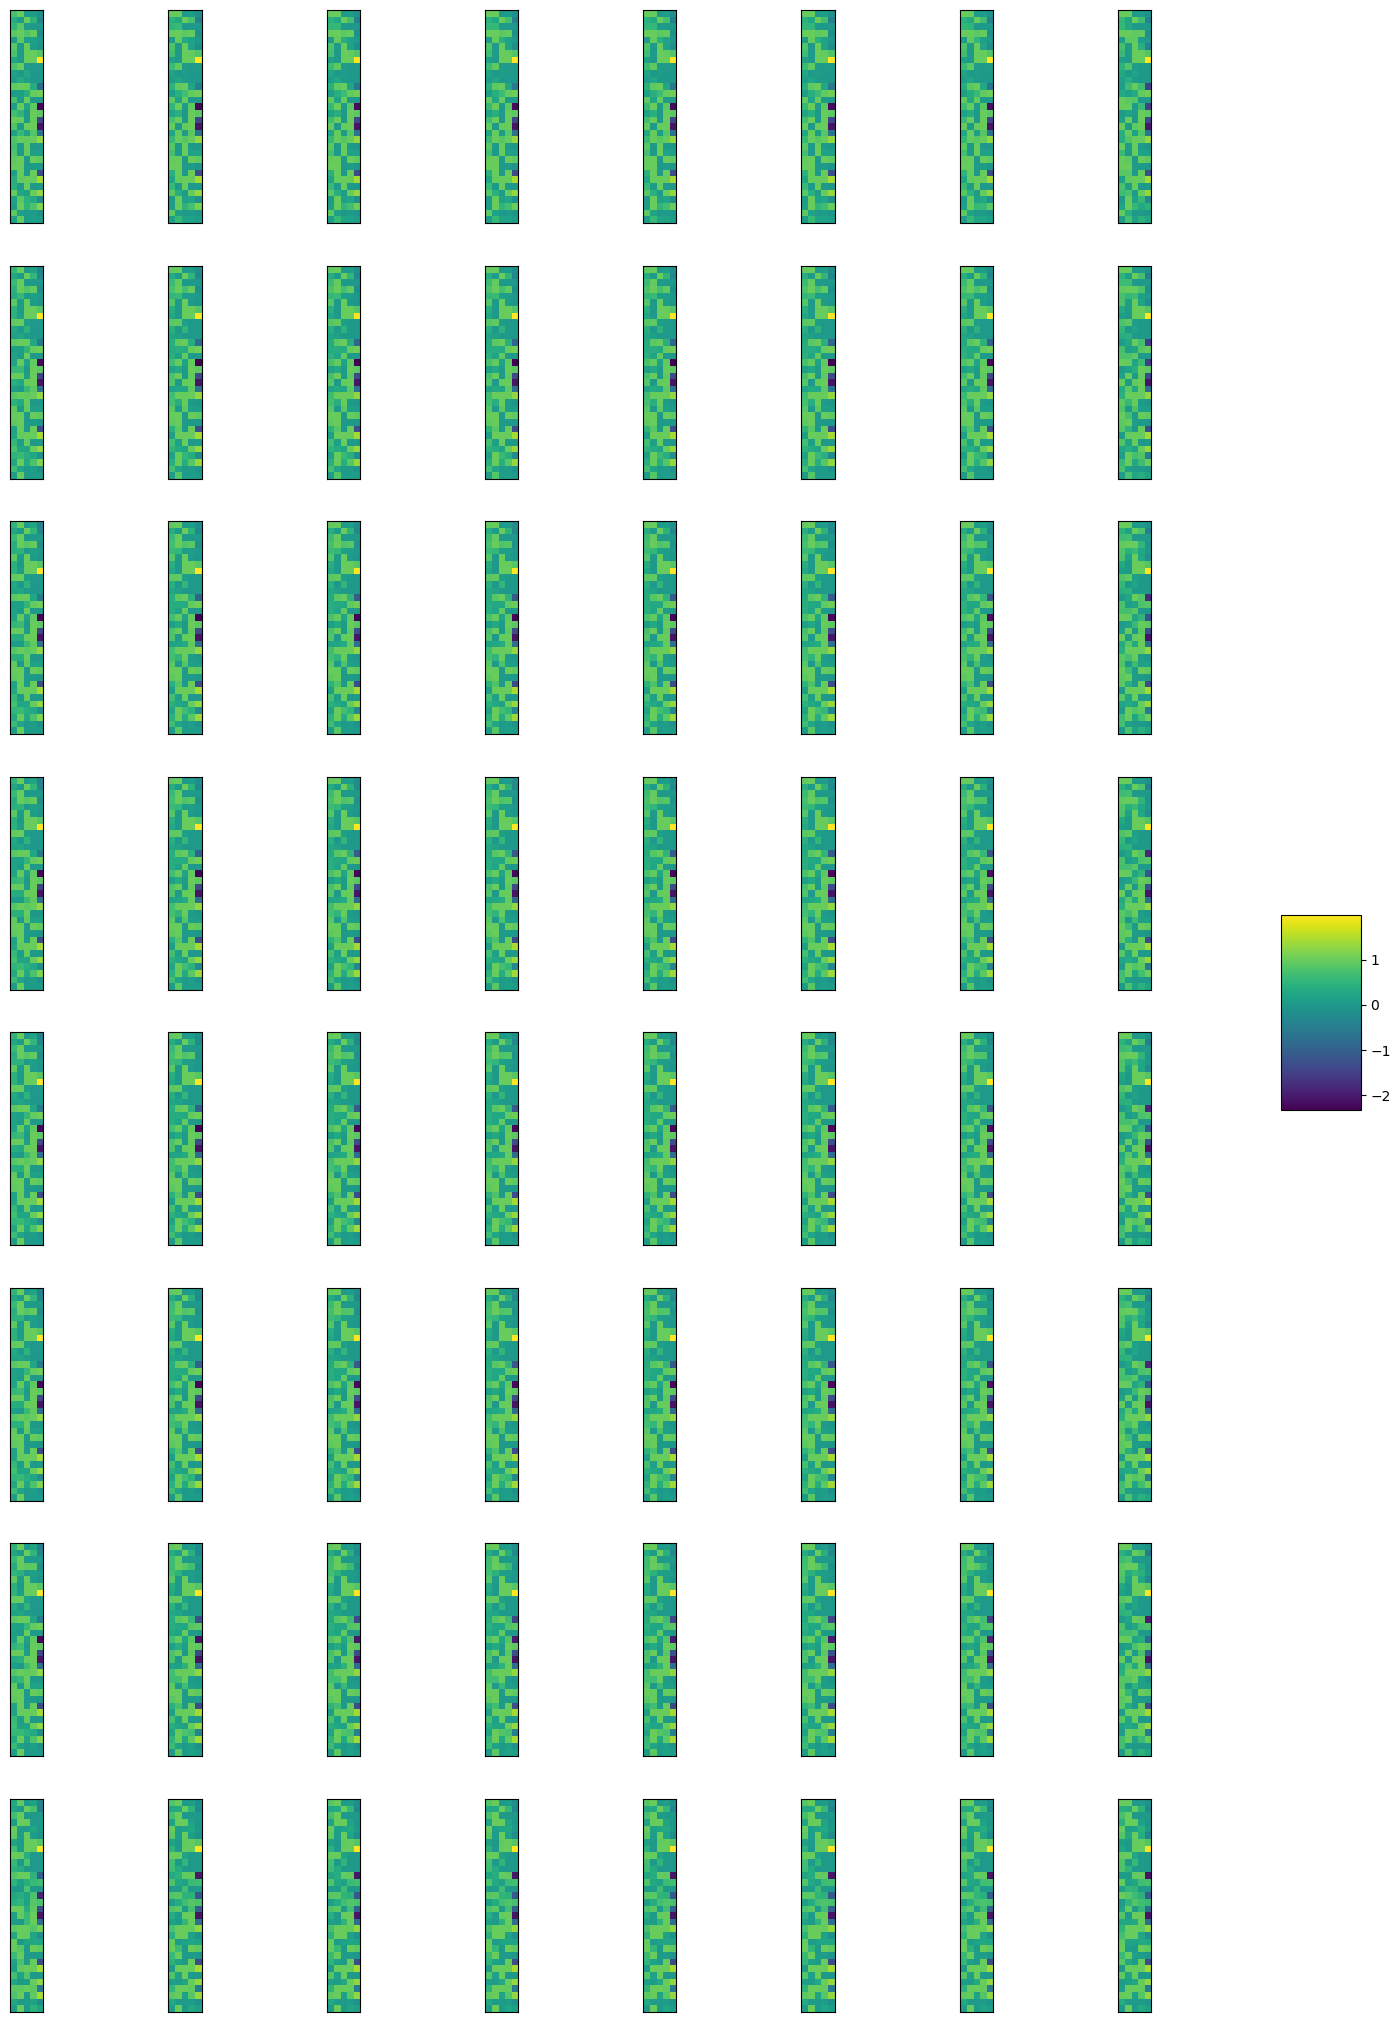

In [770]:
n_samples = 4
#xsamples = torch.linspace(-.15,.15,n_samples)

pows = torch.linspace(-3,0,n_samples)
points = 10**pows

xsamples = torch.cat((torch.flip(-1*points,dims=[0]),points))




ls_full = torch.zeros(n0,5,xsamples.size()[0],xsamples.size()[0])
for j in range(xsamples.size()[0]):
    for i in range(xsamples.size()[0]):
        xsample = xsamples[i]
        ysample = xsamples[j]
        Qsample = torch.tensor([xsample,ysample])
        
        l0, l1, l2, l3, lf = forward_activations(Qsample)
        l0 = l0.cpu().detach().numpy()
        l1 = l1.cpu().detach().numpy()
        l2 = l2.cpu().detach().numpy()
        l3 = l3.cpu().detach().numpy()
        lf = lf.cpu().detach().numpy()
        
        
        
        ls = torch.zeros(n0,5)
        #ls[:,0] = torch.tensor(l0)/(np.max(l0)-np.min(l0))
        #ls[:,1] = torch.tensor(l1)/(np.max(l1)-np.min(l1))
        #ls[:,2] = torch.tensor(l2)/(np.max(l2)-np.min(l2))
        #ls[:,3] = torch.tensor(l3)/(np.max(l3)-np.min(l3))
        #ls[:,4] = torch.tensor(lf)/(np.max(lf)-np.min(lf))
        
        ls[:,0] = torch.tensor(l0)
        ls[:,1] = torch.tensor(l1)
        ls[:,2] = torch.tensor(l2)
        ls[:,3] = torch.tensor(l3)
        ls[:,4] = torch.tensor(lf)
    
        ls_full[:,:,i,j] = ls
        #ls = ls/(torch.max(ls) - torch.min(ls))

fig, axs = plt.subplots(xsamples.size()[0],xsamples.size()[0],figsize=(16,26))

#ls_full = ls_full/(torch.max(ls_full) - torch.min(ls_full)) #normalize activations
#ls_full = torch.tanh(ls_full/(torch.max(ls_full) - torch.min(ls_full)))
#ls_full = torch.tanh(ls_full)
ls_full = torch.sign(ls_full)*torch.sqrt(torch.abs(ls_full))
norm = colors.Normalize(vmin=np.min(ls_full.cpu().detach().numpy()), vmax=np.max(ls_full.cpu().detach().numpy()))

for j in range(xsamples.size()[0]):
    for i in range(xsamples.size()[0]):
        im = axs[i,j].imshow(ls_full[:,:,i,j].cpu().detach().numpy(),origin='lower',norm=norm)
        axs[i,j].tick_params(axis='both',which='both',labelsize=0,length=0,width=0)
        axs[i,j].minorticks_off()
        axs[i,j].xaxis.set_tick_params(labelbottom=False)
        axs[i,j].yaxis.set_tick_params(labelleft=False)
        #axs[i].set_title(f'{xsamples[i]:.1e}')

cbar_ax = fig.add_axes([0.95, .457, 0.05, 0.075])
fig.colorbar(im, cax=cbar_ax)

plt.show()


indices = np.arange(0,n_samples,1)


#plt.plot(xsamples.cpu().detach().numpy(),fv(xsamples).cpu().detach().numpy(),color='orange',label='NN fit')
#plt.plot(xsamples.cpu().detach().numpy(),f_vmap(xsamples).cpu().detach().numpy(),color='blue',label=r'true $f(x)$')
#plt.xlabel(r'$x$')
#plt.ylabel(f'$f(x)$')
#plt.legend()
#plt.show()

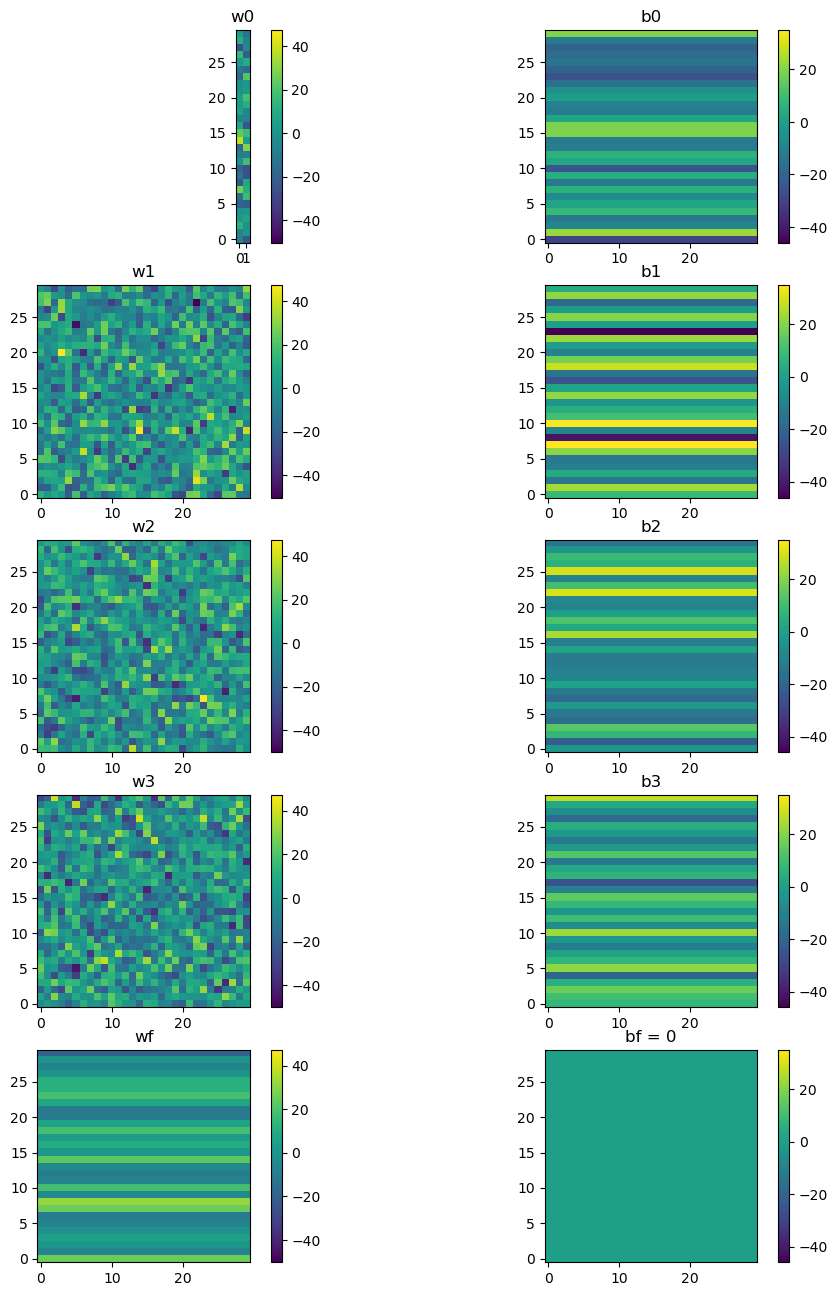

In [548]:
fig, axs = plt.subplots(5,2,figsize=(12,16))

#weights
weights_packaged = torch.cat(( w0.reshape(-1), w1.reshape(-1), w2.reshape(-1), w3.reshape(-1), wf.reshape(-1) ))
norm_w = colors.Normalize(vmin=np.min(weights_packaged.cpu().detach().numpy()), vmax=np.max(weights_packaged.cpu().detach().numpy()))

im = axs[0,0].imshow(w0.cpu().detach().numpy().T,origin='lower', norm=norm_w)
axs[0,0].set_title('w0')
fig.colorbar(im,ax=axs[0,0])

im = axs[1,0].imshow(w1.cpu().detach().numpy(),origin='lower', norm=norm_w)
axs[1,0].set_title('w1')
fig.colorbar(im,ax=axs[1,0])

im = axs[2,0].imshow(w2.cpu().detach().numpy(),origin='lower', norm=norm_w)
axs[2,0].set_title('w2')
fig.colorbar(im,ax=axs[2,0])

im = axs[3,0].imshow(w3.cpu().detach().numpy(),origin='lower', norm=norm_w)
axs[3,0].set_title('w3')
fig.colorbar(im,ax=axs[3,0])

im = axs[4,0].imshow(wf.expand([layer_size,layer_size]).T.cpu().detach().numpy(),origin='lower', norm=norm_w)
axs[4,0].set_title('wf')
fig.colorbar(im,ax=axs[4,0])

#biases

biases_packaged = torch.cat(( b0.reshape(-1), b1.reshape(-1), b2.reshape(-1), b3.reshape(-1)))
norm_b = colors.Normalize(vmin=np.min(biases_packaged.cpu().detach().numpy()), vmax=np.max(biases_packaged.cpu().detach().numpy()))

im = axs[0,1].imshow(b0.expand([layer_size,layer_size]).T.cpu().detach().numpy(),origin='lower', norm=norm_b)
axs[0,1].set_title('b0')
fig.colorbar(im,ax=axs[0,1])

im = axs[1,1].imshow(b1.expand([layer_size,layer_size]).T.cpu().detach().numpy(),origin='lower', norm=norm_b)
axs[1,1].set_title('b1')
fig.colorbar(im,ax=axs[1,1])

im = axs[2,1].imshow(b2.expand([layer_size,layer_size]).T.cpu().detach().numpy(),origin='lower', norm=norm_b)
axs[2,1].set_title('b2')
fig.colorbar(im,ax=axs[2,1])

im = axs[3,1].imshow(b3.expand([layer_size,layer_size]).T.cpu().detach().numpy(),origin='lower', norm=norm_b)
axs[3,1].set_title('b3')
fig.colorbar(im,ax=axs[3,1])

im = axs[4,1].imshow(0*b0.expand([layer_size,layer_size]).T.cpu().detach().numpy(),origin='lower', norm=norm_b)
axs[4,1].set_title('bf = 0')
fig.colorbar(im,ax=axs[4,1])



plt.show()